In [1]:
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import UndefinedMetricWarning
import warnings

warnings.filterwarnings("ignore",category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning) 

dataset = np.loadtxt("./features.txt", delimiter=" ");
print(dataset.shape)

(52580, 36)


In [2]:
import tensorflow as tf

num_labels = 2
batch_size = 256
num_features = 35
test_size = 2000
num_hidden_nodes = 4096

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float64, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float64, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float64, shape=(test_size, num_features))
    tf_test_dataset = tf.placeholder(tf.float64, shape=(test_size, num_features))
    beta_regul = tf.placeholder(tf.float64)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([num_features, num_hidden_nodes], dtype=tf.float64), dtype=tf.float64)
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes], dtype=tf.float64), dtype=tf.float64)
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels], dtype=tf.float64), dtype=tf.float64)
    biases2 = tf.Variable(tf.zeros([num_labels], dtype=tf.float64), dtype=tf.float64)

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [3]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [4]:
'''
Feature Information
Feature Set 1: Generic features
    F1 - Total Source IPs per destination IP
    F2 - Total Protocols used for communication per destination IP
    F3 - Total Bidirectional flows per destination IP
    F4 - Total Client flows per destination IP
    F5 - Total Server flows per destination IP
    F6 - Protocols used for communication represented as bit string
    
Feature Set 2: Aggregate features
    F7 : F12 - Total, Max, Min, Mean, Variance, Std of Flows per destination IP
    F13 : F18 - Total, Max, Min, Mean, Variance, Std of Packets per destination IP
    F19 : F24 - Total, Max, Min, Mean, Variance, Std of Bytes per destination IP
    F25 : F30 - Total, Max, Min, Mean, Variance, Std of SourceBytes per destination IP
    
Feature Set 3: Subnet Features
    F31 - No. of distinct IPs in dstIP/24 subnet
    F32 - Total Flows in dstIP/24 subnet
    F33 - Total Packets in dstIP/24 subnet
    
Feature Set 4: Periodic Communication Features
    F34 - Total periodic communications involved per destination IP
    F35 - Ratio of total source IPs involved in periodic communication over total source IPs involved per dst IP
'''

genericFeatures = list(range(6))
aggregateFeatures = list(range(6, 30))
subnetFeatures = list(range(30, 33))
periodicCommnFeatures = [33, 34]

genericAggregate = genericFeatures + aggregateFeatures
genericSubnet = genericFeatures + subnetFeatures
genericPeriodic = genericFeatures + periodicCommnFeatures
aggregateSubnet = aggregateFeatures + subnetFeatures
aggregatePeriodic = aggregateFeatures + periodicCommnFeatures
subnetPeriodic = subnetFeatures + periodicCommnFeatures

withoutGenericFeatures = [columnIndex for columnIndex in range(35) if columnIndex not in genericFeatures]
withoutAggregateFeatures = [columnIndex for columnIndex in range(35) if columnIndex not in aggregateFeatures]
withoutSubnetFeatures = [columnIndex for columnIndex in range(35) if columnIndex not in subnetFeatures]
withoutPeriodicCommnFeatures = [columnIndex for columnIndex in range(35) if columnIndex not in periodicCommnFeatures]
allFeatures = range(35)

configuration = [genericFeatures, aggregateFeatures, subnetFeatures, periodicCommnFeatures, 
                 genericAggregate, genericSubnet, genericPeriodic, aggregateSubnet, aggregatePeriodic, subnetPeriodic,
                 withoutGenericFeatures, withoutAggregateFeatures, withoutSubnetFeatures, withoutPeriodicCommnFeatures,
                 allFeatures
                ]

configToString = { repr(genericFeatures) : "FeatureSet 1",
                   repr(aggregateFeatures) : "FeatureSet 2",
                   repr(subnetFeatures) : "FeatureSet 3",
                   repr(periodicCommnFeatures) : "FeatureSet 4",
                   repr(genericAggregate) : "FeatureSet (1,2)",
                   repr(genericSubnet) : "FeatureSet (1,3)",
                   repr(genericPeriodic) : "FeatureSet (1,4)",
                   repr(aggregateSubnet) : "FeatureSet (2,3)",
                   repr(aggregatePeriodic) : "FeatureSet (2,4)",
                   repr(subnetPeriodic) : "FeatureSet (3,4)",
                   repr(withoutGenericFeatures) : "FeatureSet (2,3,4)",
                   repr(withoutAggregateFeatures) : "FeatureSet (1,3,4)",
                   repr(withoutSubnetFeatures) : "FeatureSet (1,2,4)",
                   repr(withoutPeriodicCommnFeatures) : "FeatureSet (1,2,3)",
                   repr(allFeatures) : "All Features"
                 }

In [5]:
valid_start_index = 0
valid_end_index = 1000
test_start_index = 1000
test_end_index = 2000

class Dataset:
    
    def __init__(self, dataset):
        np.random.shuffle(dataset)

        botnetDataset = dataset[dataset[:,35]==1, :]
        normalDataset = dataset[dataset[:,35]==0, :]

        botnetX = botnetDataset[:,:35]
        normalX = normalDataset[:,:35]
        
        self.botnetY = botnetDataset[:, 35]
        self.normalY = normalDataset[:, 35]

        scaler = MinMaxScaler(feature_range=(0, 1))
        self.origRescaledBotnetX = scaler.fit_transform(botnetX)
        self.origRescaledNormalX = scaler.fit_transform(normalX)
    
    def updateColumns(self, columns):
        truncBotX = self.origRescaledBotnetX[:, columns]
        truncNormalX = self.origRescaledNormalX[:, columns]
        return truncBotX, truncNormalX
    
    def getTrainingDataSet(self, rescaledBotnetX, rescaledNormalX):
        return rescaledBotnetX[test_end_index:,:], rescaledNormalX[test_end_index:,:], \
    self.botnetY[test_end_index:], self.normalY[test_end_index:]
    
    def getValidationDataSet(self, rescaledBotnetX, rescaledNormalX):
        validation_dataset = np.concatenate((rescaledBotnetX[valid_start_index:valid_end_index,:], 
                                         rescaledNormalX[valid_start_index:valid_end_index,:]))
        valid_labels = np.concatenate((self.botnetY[valid_start_index:valid_end_index], 
                                       self.normalY[valid_start_index:valid_end_index]))
        valid_labels = (np.arange(num_labels) == valid_labels[:,None]).astype(np.float64)
        return validation_dataset, valid_labels
        
    def getTestingDataSet(self, rescaledBotnetX, rescaledNormalX):
        test_dataset = np.concatenate((rescaledBotnetX[test_start_index:test_end_index,:], 
                                   rescaledNormalX[test_start_index:test_end_index,:]))
        test_labels = np.concatenate((self.botnetY[test_start_index:test_end_index], 
                                 self.normalY[test_start_index:test_end_index]))
        test_labels = (np.arange(num_labels) == test_labels[:,None]).astype(np.float64)
        return test_dataset, test_labels

In [23]:
regul_val = [pow(10, i) for i in np.arange( -4, -2, 0.1)]
accuracy_val = []
num_steps = 250
class_batch_size = int(batch_size)/2

datasetHelper = Dataset(dataset)
valid_dataset, valid_labels = datasetHelper.getValidationDataSet(datasetHelper.origRescaledBotnetX, 
                                                                 datasetHelper.origRescaledNormalX)
test_dataset, test_labels = datasetHelper.getTestingDataSet(datasetHelper.origRescaledBotnetX, 
                                                            datasetHelper.origRescaledNormalX)
trainBotnetX, trainNormalX, trainBotnetY, trainNormalY = datasetHelper.getTrainingDataSet(datasetHelper.origRescaledBotnetX,
                                                                                          datasetHelper.origRescaledNormalX)

for regul in regul_val:
    offset = 0
    with tf.Session(graph=graph) as session:

        tf.global_variables_initializer().run()
        for step in range(num_steps):
            np.random.shuffle(trainNormalX)
            train_batch_data = np.concatenate((trainBotnetX[offset:(offset+class_batch_size),:], 
                                   trainNormalX[:class_batch_size,:]))
            train_batch_labels = np.concatenate((trainBotnetY[:class_batch_size], 
                                 trainNormalY[:class_batch_size]))
            train_batch_labels = (np.arange(num_labels) == train_batch_labels[:,None]).astype(np.float64)
            offset = offset + class_batch_size

            feed_dict = {tf_train_dataset : train_batch_data, 
                         tf_train_labels : train_batch_labels,
                         tf_valid_dataset : valid_dataset,
                         tf_test_dataset : test_dataset,
                         beta_regul : 3e-4
                        }
            
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        feed_dict = { tf_test_dataset : test_dataset,
                      beta_regul : 3e-4 }
        print("Test accuracy for regularization param %.6f : %.1f%%" % (regul, accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels)))
        accuracy_val.append(accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))
        
print(accuracy_val)    

Test accuracy for regularization param 0.000100 : 90.3%
Test accuracy for regularization param 0.000126 : 90.3%
Test accuracy for regularization param 0.000158 : 90.9%
Test accuracy for regularization param 0.000200 : 91.0%
Test accuracy for regularization param 0.000251 : 90.2%
Test accuracy for regularization param 0.000316 : 89.7%
Test accuracy for regularization param 0.000398 : 90.1%
Test accuracy for regularization param 0.000501 : 91.0%
Test accuracy for regularization param 0.000631 : 90.8%
Test accuracy for regularization param 0.000794 : 90.4%
Test accuracy for regularization param 0.001000 : 90.4%
Test accuracy for regularization param 0.001259 : 88.2%
Test accuracy for regularization param 0.001585 : 90.8%
Test accuracy for regularization param 0.001995 : 90.0%
Test accuracy for regularization param 0.002512 : 90.3%
Test accuracy for regularization param 0.003162 : 92.4%
Test accuracy for regularization param 0.003981 : 90.4%
Test accuracy for regularization param 0.005012 

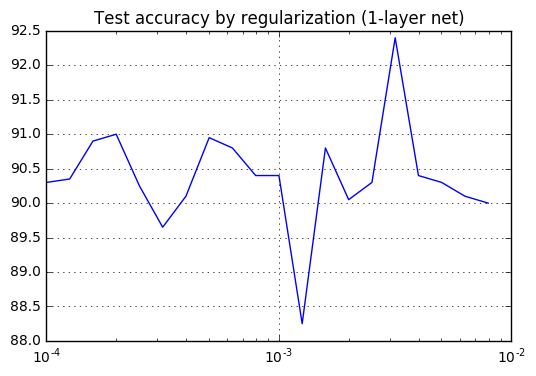

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

In [10]:
from sklearn import metrics

num_steps = 250
class_batch_size = int(batch_size)/2

for config in configuration:
    test_accuracy = []
    fpr = []
    fnr = []
    num_features = len(config)
    
    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(tf.float64, shape=(batch_size, num_features))
        tf_train_labels = tf.placeholder(tf.float64, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.placeholder(tf.float64, shape=(test_size, num_features))
        tf_test_dataset = tf.placeholder(tf.float64, shape=(test_size, num_features))
        beta_regul = tf.placeholder(tf.float64)

        # Variables.
        weights1 = tf.Variable(tf.truncated_normal([num_features, num_hidden_nodes], dtype=tf.float64), dtype=tf.float64)
        biases1 = tf.Variable(tf.zeros([num_hidden_nodes], dtype=tf.float64), dtype=tf.float64)
        weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels], dtype=tf.float64), dtype=tf.float64)
        biases2 = tf.Variable(tf.zeros([num_labels], dtype=tf.float64), dtype=tf.float64)

        # Training computation.
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        drop1 = tf.nn.dropout(lay1_train, 0.5)
        logits = tf.matmul(drop1, weights2) + biases2
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
          beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)
        
    for cross_validation in range(10):

        offset = 0
        datasetHelper = Dataset(dataset)
        truncBotX, trunNormalX = datasetHelper.updateColumns(config)
        valid_dataset, valid_labels = datasetHelper.getValidationDataSet(truncBotX, trunNormalX)
        test_dataset, test_labels = datasetHelper.getTestingDataSet(truncBotX, trunNormalX)
        trainBotnetX, trainNormalX, trainBotnetY, trainNormalY = datasetHelper.getTrainingDataSet(truncBotX, trunNormalX)
    
        with tf.Session(graph=graph) as session:

            tf.global_variables_initializer().run()
            for step in range(num_steps):
                np.random.shuffle(trainNormalX)
                train_batch_data = np.concatenate((trainBotnetX[offset:(offset+class_batch_size),:], 
                                       trainNormalX[:class_batch_size,:]))
                train_batch_labels = np.concatenate((trainBotnetY[:class_batch_size], 
                                     trainNormalY[:class_batch_size]))
                train_batch_labels = (np.arange(num_labels) == train_batch_labels[:,None]).astype(np.float64)
                offset = offset + class_batch_size

                feed_dict = {tf_train_dataset : train_batch_data, 
                             tf_train_labels : train_batch_labels,
                             tf_valid_dataset : valid_dataset,
                             tf_test_dataset : test_dataset,
                             beta_regul : 3e-4
                            }

                _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)

            feed_dict = { tf_test_dataset : test_dataset,
                          beta_regul : 3e-4 }
            predicted = test_prediction.eval(feed_dict=feed_dict)
            test_accuracy.append(accuracy(predicted, test_labels))
            fpr.append(metrics.precision_score(np.argmax(test_labels, 1), np.argmax(predicted, 1)))
            fnr.append(metrics.recall_score(np.argmax(test_labels, 1), np.argmax(predicted, 1)))

    print("Feature Config: %s, Avg Accuracy: %.3f, Avg Precision Rate: %.3f, Avg Recall Rate: %.3f" %
            (configToString[repr(config)], np.mean(test_accuracy), np.mean(fpr), np.mean(fnr)))

Feature Config: FeatureSet 1, Avg Accuracy: 84.365, Avg Precision Rate: 0.764, Avg Recall Rate: 0.994
Feature Config: FeatureSet 2, Avg Accuracy: 54.885, Avg Precision Rate: 0.623, Avg Recall Rate: 0.600
Feature Config: FeatureSet 3, Avg Accuracy: 72.685, Avg Precision Rate: 0.663, Avg Recall Rate: 0.926


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Feature Config: FeatureSet 4, Avg Accuracy: 50.905, Avg Precision Rate: 0.455, Avg Recall Rate: 0.900
Feature Config: FeatureSet (1,2), Avg Accuracy: 86.910, Avg Precision Rate: 0.800, Avg Recall Rate: 0.985
Feature Config: FeatureSet (1,3), Avg Accuracy: 89.900, Avg Precision Rate: 0.855, Avg Recall Rate: 0.962
Feature Config: FeatureSet (1,4), Avg Accuracy: 85.220, Avg Precision Rate: 0.777, Avg Recall Rate: 0.987
Feature Config: FeatureSet (2,3), Avg Accuracy: 71.370, Avg Precision Rate: 0.703, Avg Recall Rate: 0.834
Feature Config: FeatureSet (2,4), Avg Accuracy: 53.870, Avg Precision Rate: 0.646, Avg Recall Rate: 0.499
Feature Config: FeatureSet (3,4), Avg Accuracy: 73.845, Avg Precision Rate: 0.675, Avg Recall Rate: 0.921
Feature Config: FeatureSet (2,3,4), Avg Accuracy: 75.020, Avg Precision Rate: 0.683, Avg Recall Rate: 0.937
Feature Config: FeatureSet (1,3,4), Avg Accuracy: 90.445, Avg Precision Rate: 0.858, Avg Recall Rate: 0.970
Feature Config: FeatureSet (1,2,4), Avg Accura